# Hero Run for Training Simple Feed Forward Ensamble

So not sure how mpi will be calling the models, but potentially x72 models. I wanted to have an ensamble of 3 models to calc the average output. So need x216 models, at 200 MB is 43.2 GB. Further investigation is needed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torch.amp import autocast
from torch.amp import GradScaler

import h5py as h5

import matplotlib.pyplot as plt

from os.path import join

We are going to do hybrid heterogenious computing, so assert GPU is available

In [2]:
assert torch.cuda.is_available(), 'CUDA is not available.'

## Simple FF Model

Simple FF net. Flatten input so $(3*2*2 + 70*2*2*2)=852$. And flatten output $(70*2*2*2)=560$.
Also use float32 to minimize size (can move to float64 later), CESM will output float64 so will need to handle inside the ensamble

In [3]:
class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.fc1 = nn.Linear(852,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 560)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
model = simpleNN()
model = model.double().cuda()

## Data Loading

Data was pre partitioned into training and test dataset

In [5]:
train_name = join('/home/squirt/Documents/data/weather_data/', 'train_data.h5')
test_name = join('/home/squirt/Documents/data/weather_data/', 'test_data.h5')

Method to load hdf5 file of the processed weather data

In [6]:
def load_hdf5(filename:str):
    '''
    Load data from an HDF5 file and return a list of dictionaries.
    Inputs:
        - filename (str): Path to the HDF5 file.
    Outputs:
        - data (list): List of dictionaries, where each dictionary represents an entry in the original list.
    '''
    data = []  # List to hold dictionaries
    with h5.File(filename, 'r') as f:
        # Iterate through groups (each representing an entry in the original list)
        for group_name in f:
            group = f[group_name]
            # Reconstruct dictionary from datasets and attributes
            entry = {
                # Attributes (metadata)
                'day': group.attrs['day'],
                'region': group.attrs['region'],
                'time': group.attrs['time'],

                # groups (numpy arrays)
                'landmass': group['landmass'][...],  # Use [...] to read the full dataset
                'x': group['x'][...],
                'y': group['y'][...],
            }
            data.append(entry)
    return data

Generate stacks to train

In [7]:
def normalize_tensor(data:torch.tensor):
    # Compute mean and std along the batch_size, x1, and x2 dimensions
    mean = data.mean(dim=(0, 3, 4), keepdim=True)
    std = data.std(dim=(0, 3, 4), keepdim=True)
    
    # Normalize the data
    normalized_data = (data - mean) / (std + 1e-7)  # Add a small constant to avoid division by zero
    
    return normalized_data, mean, std

def stack_data(data:list[dict], key:str) -> torch.Tensor:
    return torch.stack([torch.tensor(entry[key]) for entry in data])


def generate_stacks(data:list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Create a PyTorch DataLoader from the data.
    Inputs:
        - data (list): List of dictionaries, where each dictionary represents an entry in the original list.
    Outputs:
        - landmass (torch.Tensor): Tensor of landmass data.
        - x (torch.Tensor): Tensor of x-coordinate data.
        - y (torch.Tensor): Tensor of y-coordinate data.
    '''
    landmass = stack_data(data, 'landmass')

    x = stack_data(data, 'x')
    x = x.transpose(2, 1)

    y = stack_data(data, 'y')
    y = y.transpose(2, 1)
    
    if True:
        #landmass, _, _= normalize_tensor(landmass)
        x, _, _ = normalize_tensor(x)
        y, _, _ = normalize_tensor(y)
    
    return (landmass, x, y)


class weather_dataset(Dataset):
    '''
    PyTorch Dataset class for weather data.
    '''
    def __init__(self, data:list[dict]):
        self.landmass, self.x, self.y = generate_stacks(data)
        self.length = len(self.landmass)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return (self.landmass[idx], self.x[idx], self.y[idx])

Partition training data into train and validation sets.

In [8]:
def get_dataloaders(fname:str, batch_size:int, split:int) -> tuple[DataLoader, DataLoader]:
    '''
    Create PyTorch DataLoader objects for training and validation data.
    Inputs:
        - fname (str): Path to the HDF5 file.
        - batch_size (int): Batch size for the DataLoader objects.
        - split (float): Fraction of the data to use for training.     
    Outputs:
        - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        - test_loader (torch.utils.data.DataLoader): DataLoader for test data.
    '''
    # Load data and create tensor 
    data = load_hdf5(fname)
    dataset = weather_dataset(data)
    
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split data into training and validation sets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    return train_loader, test_loader

## Training Loop 

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Define training loop, use mixed percision training

In [10]:
def train(model:nn.Module, dl:torch.utils.data.DataLoader, optim:torch.optim, loss:nn.Module) -> float:
    model.train()
    total_loss = .0
    scaler = GradScaler()

    for _, (l, x, y) in enumerate(dl):
        l = l.cuda()
        x = x.cuda()
        y = y.cuda()

        # Flatten and combine
        l = l.view(-1, 3*2*2)
        x = x.view(-1, 70*3*2*2)
        x = torch.cat((l, x), 1)

        y = y.view(-1, 70*2*2*2)

        # Forward pass
        optim.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            y_pred = model(x)
            l = loss(y_pred, y)
            total_loss += l.item()

        # Preform backpass
        scaler.scale(l).backward()
        scaler.step(optim)
        scaler.update()
    
    return total_loss / len(dl)

Eval Loop

In [11]:
def eval(model:nn.Module, dl:torch.utils.data.DataLoader, loss:nn.Module) -> float:
    model.eval()
    total_loss = .0

    for _, (l, x, y) in enumerate(dl):
        l = l.cuda()
        x = x.cuda()
        y = y.cuda()

        # Flatten and combine
        l = l.view(-1, 3*2*2)
        x = x.view(-1, 70*3*2*2)
        x = torch.cat((l, x), 1)

        y = y.view(-1, 70*2*2*2)

        # Forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            y_pred = model(x)
            l = loss(y_pred, y)
            total_loss += l.item()

    return total_loss / len(dl)

In [12]:
train_loss = nn.MSELoss()

## Training

TODO - Normalize data

In [13]:
folds = 3 
models = {}

test_ds = weather_dataset(load_hdf5(test_name)) 
test_loader = DataLoader(test_ds, batch_size=4096, shuffle=True, num_workers=8, pin_memory=True)

for i in range(folds):
    loss_fn = nn.MSELoss()
    model = simpleNN()
    model = model.double().cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Get Dataloaders
    train_loader, val_loader = get_dataloaders(train_name, 4096, 0.6)

    # Early Stopping 
    eval_loss = -1*float('inf') 
    train_loss  = float('inf') 
    j = 0
    print(f'Fold {i+1}')
    while train_loss > eval_loss:
        prev_eval_loss = eval_loss
        train_loss = train(model, train_loader, optimizer, loss_fn)
        eval_loss = eval(model, val_loader, loss_fn)
        print(f'\tEpoch {j} - Eval Loss: {eval_loss}')
        
        if abs(eval_loss - prev_eval_loss) < 0.01:
            print(f'\tEarly stopping at epoch {j} due to minimal change in eval loss')
            break
        j += 1

    # Test Loss
    test_loss = eval(model, test_loader, loss_fn)
    print(f'Fold {i+1} - Test Loss: {test_loss}')

    # Save Model
    model.eval()
    models[i] = model


Fold 1
	Epoch 0 - Eval Loss: 29.7851680067282
	Epoch 1 - Eval Loss: 23.65980328487721
	Epoch 2 - Eval Loss: 6.5448894384002605
	Epoch 3 - Eval Loss: 1.8851408556891256
	Epoch 4 - Eval Loss: 1.1045491385630486
	Epoch 5 - Eval Loss: 0.8789149030299661
	Epoch 6 - Eval Loss: 0.7800735160576907
	Epoch 7 - Eval Loss: 0.7099392786074348
	Epoch 8 - Eval Loss: 0.6866025567318492
	Epoch 9 - Eval Loss: 0.6594268622733228
	Epoch 10 - Eval Loss: 0.6134300381557709
	Epoch 11 - Eval Loss: 0.6106127406615971
	Early stopping at epoch 11 due to minimal change in eval loss
Fold 1 - Test Loss: 0.5945632572672598
Fold 2
	Epoch 0 - Eval Loss: 37.57989360345459
	Epoch 1 - Eval Loss: 20.835468885582564
	Epoch 2 - Eval Loss: 5.80904462443472
	Epoch 3 - Eval Loss: 1.9394103698292366
	Epoch 4 - Eval Loss: 1.3072465251215792
	Epoch 5 - Eval Loss: 0.9852905246836579
	Epoch 6 - Eval Loss: 0.805906902555038
	Epoch 7 - Eval Loss: 0.7441681801307551
	Epoch 8 - Eval Loss: 0.6924293226904148
	Epoch 9 - Eval Loss: 0.6674

## Plotting

In [14]:
def get_cell_data(t:torch.tensor) -> torch.tensor:
    t = t.view(-1, 70, 2, 2, 2)
    # T and QV are the 2 STD channels with a 2x2 grid
    # We want to get the top left cell for both channels
    p = t[:,:,:,0,0]
    p = p.view(-1, 70, 2)
    return p

In [15]:
def plot_column(data_dict:dict, idx:int):
    if idx not in {0,1}:
        raise ValueError('idx must be 0 or 1')
    title = 'Temp' if idx == 0 else 'QV'

    # Get the data for the 1st column (were just trying to determin if we want to park model for now)
    data = []
    for _,v in data_dict.items():
        data.append(v[0][0,:,idx])

    #print(data[0][:,0])
    data = torch.stack(data)
    #print(data[0,:,0])

    # Calculate Mean and STD
    mean = (data.mean(dim=0)).cpu().numpy()
    std = (data.std(dim=0)).cpu().numpy()

    # Get Real Values
    real = (data_dict[0][1][0,:,idx]).cpu().numpy()

    # Plot
    # Plotting
    plt.figure(figsize=(10, 6))
    x = range(len(mean))
            
    plt.plot(x, real, label='True Value', color='blue', linestyle='None', marker='o')
    plt.plot(x, mean, label='Mean Prediction', color='red', linestyle='--')
    plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2, label='Prediction Std Dev')

    plt.title(f'{title} Predictions vs True Values')
    plt.xlabel('Cell')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
batch_data = next(iter(test_loader))
l, x, y = batch_data
l = l.cuda()
x = x.cuda()
y = y.cuda()

# Flatten and combine
l = l.view(-1, 3*2*2)
x = x.view(-1, 70*3*2*2)
x = torch.cat((l, x), 1)

y = y.view(-1, 70*2*2*2)

In [17]:
model_preds = {}
for i, model in models.items():
    with torch.no_grad():
        y_hat = model(x)
        model_preds[i] = (y_hat, y)

In [18]:
plot_values = {}
for k,v in model_preds.items():
    plot_values[k] = (get_cell_data(v[0]), get_cell_data(v[1]))

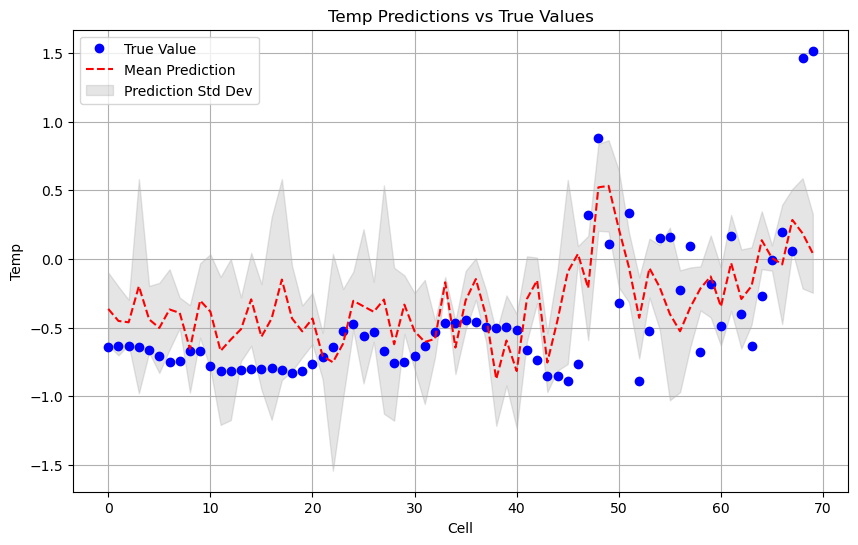

In [19]:
plot_column(plot_values, 0)

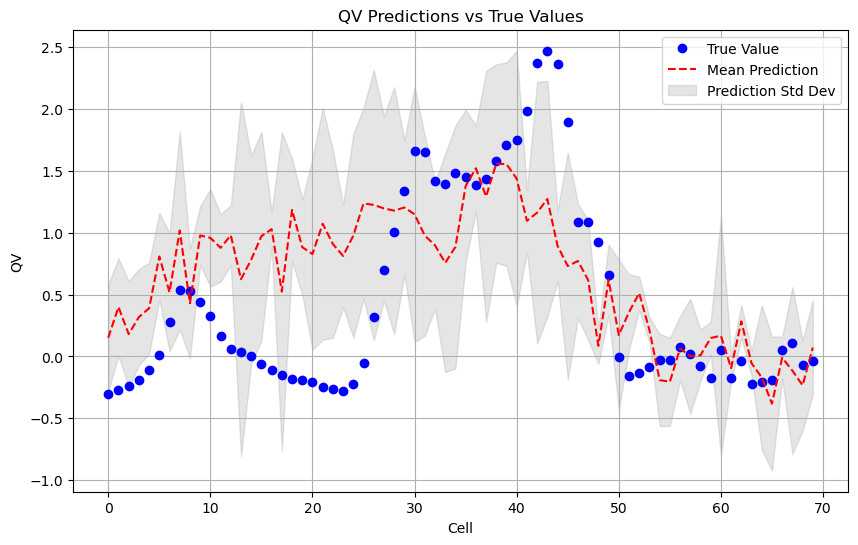

In [20]:
plot_column(plot_values, 1)

## Save Model

In [21]:
for i,m in models.items():
    try:
        script_model = torch.jit.script(m)
        script_model.save(f"./weights/simple_net_{i}.pt")
        print(f"Model {i} saved successfully.")
    except Exception as e:
        print(f"Error saving model {i}: {e}")

Model 0 saved successfully.
Model 1 saved successfully.
Model 2 saved successfully.
